In [33]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
import fastwer

imgs = np.expand_dims(np.load('../dataset/cv/train/x/generated_text.npz')['arr_0'], axis=-1)
imgs = np.transpose(imgs, (0, 2, 1, 3))
labels = np.load('../dataset/cv/train/y/generated_labels.npy')
characters = set(char for label in labels for char in label)
t_dist_dim = int(128)

setGPU: Setting GPU to: 0


In [50]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [3]:
net = build_and_compile_model_v9_7(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")

In [4]:
net.load_weights('weights/CRNN_v9_7.h5')

In [42]:
def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

def encoding_to_label(pred):
    lst = []
    for label in pred:
        b = label.squeeze()[np.argwhere(label.squeeze()!=b'[UNK]')]
        tmp = ''
        if len(b) == 1:
            tmp = b[0][0].decode('UTF-8')
        else:
            for char in b.squeeze():
                tmp += char.decode('UTF-8')
        lst.append(tmp)
    return lst

def predict_text(imgs, net, t_dist_dim):
    if len(imgs.shape) == 3:
        imgs = np.expand_dims(imgs, axis=0)
    t_dim = np.full((imgs.shape[0],), t_dist_dim)
    pred_tensor, _ = decode_ctc([net.predict(imgs), t_dim])
    pred_labels = tf.keras.backend.get_value(pred_tensor[0])
    return encoding_to_label(num_to_char(pred_labels).numpy())

def predict_random_text(size, gen, net, t_dist_dim):
    preds = []
    y_true = []
    for _ in range(size):
        img, lbl = next(gen)
        y_true.append(lbl)
        im = cv2.resize(np.array(img), (128, 128))
        im = color.rgb2gray(im)
        im = np.expand_dims(im, axis=-1)
        im = np.transpose(im, (1, 0, 2))
        pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
        pred_labels = tf.keras.backend.get_value(pred_tensor[0])
        preds.append(encoding_to_label(num_to_char(pred_labels).numpy())[0])
    return preds, y_true

In [328]:
import cv2
from skimage import color
from trdg.generators import GeneratorFromRandom, GeneratorFromWikipedia

#base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=2, width=128, size=32, space_width=2.0)
base_generator = GeneratorFromWikipedia(width=128, size=32, space_width=2.0)

In [7]:
training_preds = predict_text(imgs, net, t_dist_dim)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [8]:
#Metrica su training set

score = 0
for i in range(len(training_preds)):
    score += fastwer.score_sent(training_preds[i], labels[i], char_level=True)
score = score / len(training_preds)
print(score)

1.3068172800000017


In [12]:
#Metrica su test set
test_preds, test_labels = predict_random_text(500, base_generator, net, t_dist_dim)
test_score = 0
for i in range(len(test_preds)):
    test_score += fastwer.score_sent(test_preds[i], test_labels[i], char_level=True)
test_score = test_score / len(test_preds)
print(test_score)

3.423968199999999


In [51]:
test_preds

['3qiaahawn5ka9nilvrk', 'OvicoIa', 'Binomialname', 'kM8yb6848lbhiaA']

In [52]:
test_labels

['clade Heterobranchiaclade Euthyneuraclade Panpulmonata',
 'O vicola',
 'Binomial name',
 'Odostomia vicolaDall Bartsch 1909']

In [34]:
from mod_v11 import *
net2 = build_and_compile_model_v11(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")
net2.load_weights('weights/CRNN_v11.h5')

In [70]:
test_set = []
y_true = []
for _ in range(5000):
    img, lbl = next(base_generator)
    y_true.append(lbl)
    im = cv2.resize(np.array(img), (128, 128))
    im = color.rgb2gray(im)
    im = np.expand_dims(im, axis=-1)
    im = np.transpose(im, (1, 0, 2))
    test_set.append(im)
test_set = np.array(test_set)

In [71]:
pred_1 = predict_text(test_set, net, t_dist_dim)
pred_2 = predict_text(test_set, net2, t_dist_dim)

In [72]:
test_score1 = 0
test_score2 = 0
for i in range(len(test_set)):
    test_score1 += fastwer.score_sent(pred_1[i], y_true[i], char_level=True)
    test_score2 += fastwer.score_sent(pred_2[i], y_true[i], char_level=True)
test_score1 = test_score1 / len(pred_1)
test_score2 = test_score2 / len(pred_2)
print(test_score1)
print(test_score2)

3.0066504400000027
2.9954759000000033


Prediction su frasi, separando le parole

In [14]:
import matplotlib.pyplot as plt

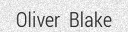

In [329]:
img, _ = next(base_generator)
im = cv2.resize(np.array(img), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)
im = np.transpose(im, (1, 0, 2))
display(img)

In [330]:
im = color.rgb2gray(np.array(img))

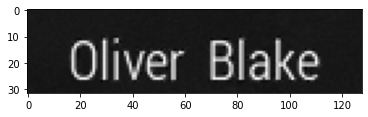

In [331]:
saltpepper = cv2.fastNlMeansDenoising(np.uint8(im*255),None, 13,2)
plt.imshow(255-saltpepper, cmap='gray')
plt.show()

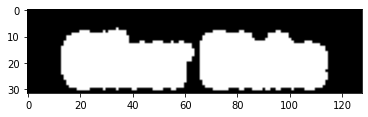

In [332]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
dilated = cv2.dilate(1-saltpepper, kernel)
dilated[dilated > 128] = 255
dilated[dilated <= 128] = 0
plt.imshow(dilated, cmap='gray')
plt.show()

In [333]:
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: min(min(c[:, :, 0])))
words = []
for i in range(len(contours)):

    mask = np.zeros((32, 128), dtype=np.uint8)

    # i is the contour to draw, -1 means fill the contours
    mask = cv2.drawContours(mask, contours, i, 255, -1)
    masked_img = cv2.bitwise_and(255-saltpepper, 1-saltpepper, mask=mask)
    masked_img[masked_img<=90] = 0
    masked_img = masked_img/255
    masked_img = 1-masked_img
    #masked_img[masked_img>=0.9] = 0.86
    words.append(masked_img)

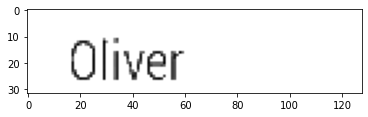

In [334]:
plt.imshow(words[0], cmap='gray')
plt.show()

In [342]:
test_img = cv2.resize(words[1], (128, 128))
test_img = np.expand_dims(test_img, axis=-1)
test_img = np.transpose(test_img, (1, 0, 2))

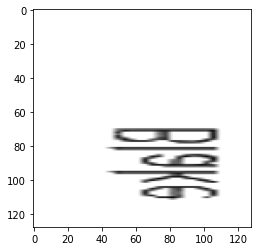

In [343]:
plt.imshow(test_img, cmap='gray')
plt.show()

In [344]:
pred_tensor, _ = decode_ctc([net2.predict(np.expand_dims(test_img, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

In [345]:
pred_labels

array([[11, 47, 36, 46, 40, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [346]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'B', b'l', b'a', b'k', b'e', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',